<h1>Company: <font color="blue">American Tire Distributors<br></font></h1>
     <b>Author:</b> Rajat Handa</a> <br>
     <b>Email:</b> Handagmu@gmail.com<br>
     <br><b>Goal:</b> To build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

### Libraries

In [449]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings('always')
import pickle
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from collections import Counter
from imblearn.over_sampling import ADASYN

### Data Loading and Mapping

In [1]:
df=pd.read_csv("fraud.csv",encoding="utf-8")
df1=pd.read_csv("IpAddress_to_Country.csv")

In [2]:
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [3]:
df1.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


<h4>Target Class Distribution</h4>

Text(0,0.5,'Number of Observations')

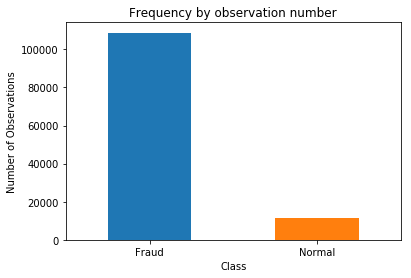

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
count_classes = pd.value_counts(df['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Fraud','Normal'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

The data seems to be highly imbalanced. This will be problem while training the models.

In [8]:
s = pd.IntervalIndex.from_arrays(df1.lower_bound_ip_address, df1.upper_bound_ip_address, 'both')

In [9]:
df_test=df[:5]
df_test.assign(country=df1.set_index(s).loc[df_test.ip_address].country.values)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [10]:
df.ip_address=df.ip_address.astype(int)
df.dtypes

Unnamed: 0         int64
user_id            int64
signup_time       object
purchase_time     object
purchase_value     int64
device_id         object
source            object
browser           object
sex               object
age                int64
ip_address         int64
class              int64
dtype: object

In [11]:
df1.lower_bound_ip_address=df1.lower_bound_ip_address.astype(int)
df1.dtypes

lower_bound_ip_address     int64
upper_bound_ip_address     int64
country                   object
dtype: object

In [12]:
df1.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [23]:
df1=df1.set_index(s)

In [14]:
df1.upper_bound_ip_address.max()

3758096383

In [15]:
df1.lower_bound_ip_address.min()

16777216

<h4>Mapping IP ranges for each country to IP Address(Partial Dataset)</h4>

In [30]:
df_test=df[1:15]
df_test["country"] = ""
def check_ip(vi):
    a=[]
    a=s.map(lambda x: vi in x)
    i = iter(a)
    return all(any(i) for j in range(1)) and not any(i)


    
for i in range(0,14):
    ip_t=df_test["ip_address"].iloc[i]
    #print(ip_t)
    bolv=check_ip(ip_t)
    #print(bolv)
    if bolv == True:
        #print(df1.loc[ip_t].country)
        df_test.country.iloc[i]=df1.loc[ip_t].country
        #print(df_test.country[i])
    else:
        continue
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
df_test.head(15)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0,United Kingdom
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2727760440,0,United States
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2083419525,0,Korea Republic of
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3207912663,0,Brazil
5,103053,178528,2015-04-20 20:19:35,2015-08-03 20:17:47,35,HUFZWLDYJPRCK,SEO,Chrome,F,30,2550203819,0,United States
6,71773,323775,2015-06-30 07:34:31,2015-09-05 16:59:33,28,DLOOEWQCUQRKZ,SEO,Safari,M,47,4075993923,0,
7,143439,69189,2015-03-10 01:53:23,2015-06-30 17:37:02,21,NRJPZDBHXNQJG,SEO,FireFox,F,47,2753449046,0,Germany
8,101025,70424,2015-07-05 16:54:42,2015-08-25 16:08:56,43,YDLNPVEWMTMMZ,Direct,IE,M,40,3310808206,0,South Africa
9,63154,328496,2015-07-23 12:48:07,2015-10-20 13:01:20,40,HTOCRWCBYIQJI,Ads,Safari,M,33,2185371169,0,France
10,14677,182104,2015-04-07 07:59:02,2015-06-13 16:49:45,69,SPVQVNLIPZJWM,Ads,Chrome,M,35,2621939114,0,United States


<h4>Mapping IP ranges for each country to IP Address(Entire Dataset)</h4>

In [33]:
%timeit
df['country']=""
def check_ip(vi):
    a=[]
    a=s.map(lambda x: vi in x)
    i = iter(a)
    return all(any(i) for j in range(1)) and not any(i)


    
for i in range(1,df.shape[0]):
    ip_t=df["ip_address"].iloc[i]
    #print(ip_t)
    bolv=check_ip(ip_t)
    if bolv == True:
        df.country.iloc[i]=df1.loc[ip_t].country
        #print(df_test.country[i])
    else:
        continue
    

In [35]:
df.tail(50)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
119950,37361,213844,2015-04-01 01:10:18,2015-05-10 08:04:14,45,KCPPDGQAPRIMC,Ads,IE,F,39,409999957,0,United States
119951,77475,100771,2015-03-22 16:57:13,2015-04-04 20:16:04,41,KRJEGKMJSDPUN,Ads,Chrome,F,32,4197714918,0,
119952,95189,6242,2015-05-10 23:48:26,2015-07-19 14:45:11,30,STLYCYBRCEJOF,Direct,FireFox,F,20,3260164427,0,United Kingdom
119953,142175,270666,2015-03-16 05:58:02,2015-03-24 07:15:38,10,AQYSHSOLZYKMS,Ads,Safari,M,33,674766110,0,United States
119954,31718,2227,2015-08-10 13:30:16,2015-09-23 03:04:11,56,OBAATUXIXRLVZ,SEO,IE,F,38,2802288933,0,United States
119955,134659,343231,2015-05-18 02:41:13,2015-08-02 19:28:13,9,VVVHRQPVMDMVN,SEO,Chrome,M,29,476581190,0,United States
119956,130382,6016,2015-03-21 19:36:22,2015-04-20 19:55:30,18,BZVCBXDMNBNPU,SEO,IE,F,26,916699260,0,United States
119957,128159,118441,2015-07-03 13:03:07,2015-07-03 16:14:51,35,JXBLAXJRCSMAZ,SEO,Safari,F,42,3726883059,0,China
119958,112195,330662,2015-04-10 23:13:51,2015-06-23 21:13:13,47,ZTWGIPERJCEQM,Ads,Chrome,F,27,268009595,0,United States
119959,66325,90327,2015-07-09 09:52:44,2015-09-11 10:33:53,45,SWHYUYTQABAIE,Ads,FireFox,M,32,2951510536,0,Korea Republic of


In [36]:
df.to_pickle("ATDjoin.pkl")

In [37]:
df3 = pd.read_pickle('ATDjoin.pkl')

In [39]:
df3.shape

(120000, 13)

In [45]:
df1.set_index(s).loc['2661960100'].country

'Chile'

In [46]:
(df['country'] == '').sum()

17419

In [53]:
normal_df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2818400139,0,
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0,United Kingdom
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2727760440,0,United States
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2083419525,0,Korea Republic of
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3207912663,0,Brazil


### Exploratory Data Analysis

In [54]:
df['purchase_dates'] = pd.to_datetime(df['purchase_time']).dt.date
df['purchase_t'] = pd.to_datetime(df['purchase_time']).dt.time
normal_df = df[df["class"] == 0]
fraud_df = df[df["class"] == 1]

#### Amount Percentage Fraud-Normal Visualization

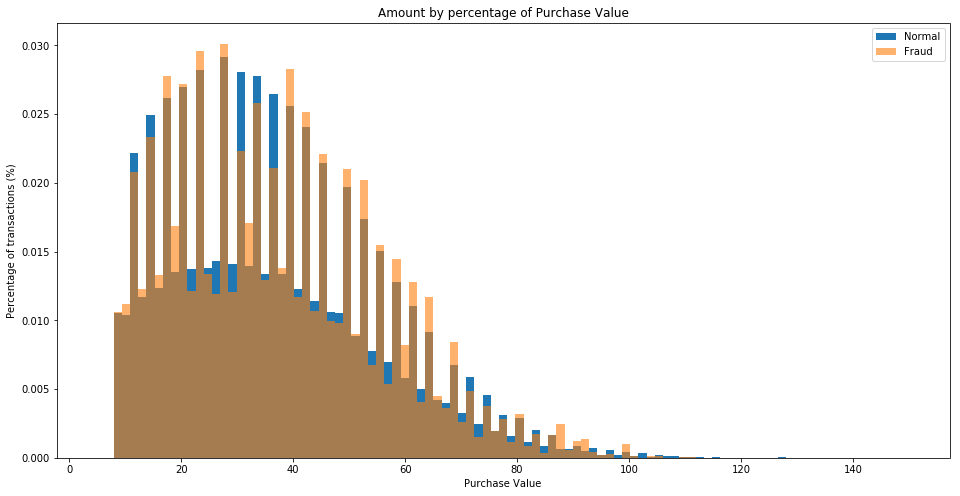

In [70]:
bins = np.linspace(5, 150, 100)
plt.subplots(figsize = (16,8))
plt.hist(normal_df.purchase_value, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.purchase_value, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of Purchase Value")
plt.xlabel("Purchase Value")
plt.ylabel("Percentage of transactions (%)");
plt.show()

From above bar chart the purchase value amount looks more variable. In the long tail, especially we have less instances to differentiate fraud from normal tansaction by having purchase value alone.

#### Month based Fraud-Normal Visualization

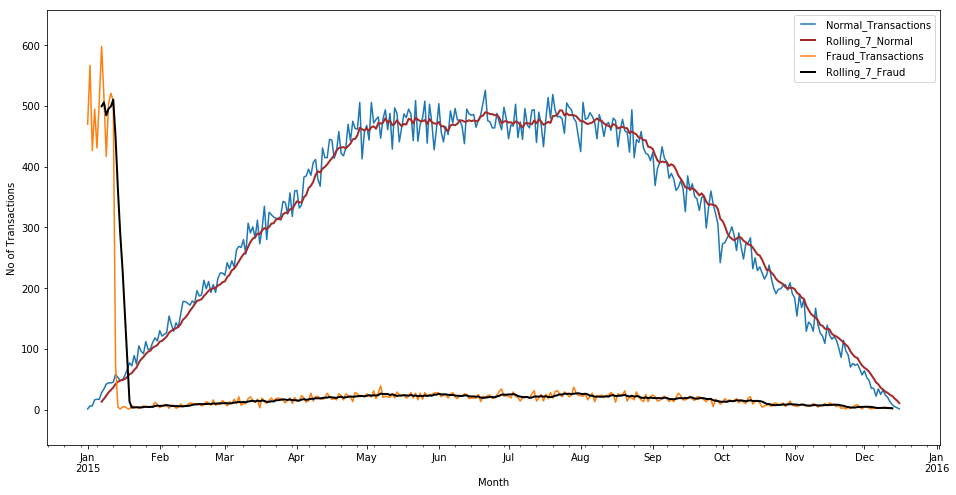

In [86]:
normal_df['purchase_dates'] = normal_df['purchase_dates'].astype('datetime64[ns]')
fraud_df['purchase_dates'] = fraud_df['purchase_dates'].astype('datetime64[ns]')
time_series = pd.DataFrame(normal_df['purchase_dates'].value_counts().sort_index())
time_series2 = pd.DataFrame(fraud_df['purchase_dates'].value_counts().sort_index())
fig, ax = plt.subplots(figsize = (16,8))
time_series.loc[:'2015-12-16'].plot(ax = ax,label='continuous')
time_series.rolling(window=7).mean().plot(ax = ax, linewidth = 2,color = "brown",label='continuous')
time_series2.loc[:'2015-12-16'].plot(ax = ax,label='continuous')
time_series2.rolling(window=7).mean().plot(ax = ax, linewidth = 2,color = 'k',label='continuous')
ax.margins(None,0.1)
ax.legend(['Normal_Transactions','Rolling_7_Normal','Fraud_Transactions','Rolling_7_Fraud'], loc = 'upper right', numpoints = 3)
ax.set_xlabel('Month')
ax.set_ylabel('No of Transactions')
ax.set_facecolor('white')

From the above timeseries, the trend for fraudlent activities seems to be varying depending on the month. This may be one of the most contributing feature to the classifier.

#### Hour of the day Fraud-Normal Visualization

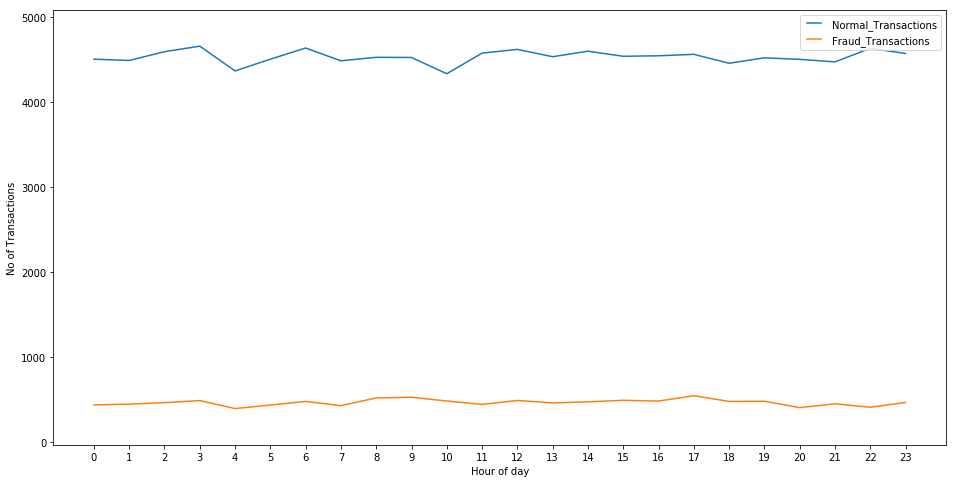

In [87]:
normal_df[['h','m','s']] = normal_df['purchase_t'].astype(str).str.split(':', expand=True).astype(int)
fraud_df[['h','m','s']] = fraud_df['purchase_t'].astype(str).str.split(':', expand=True).astype(int)
time_series = pd.DataFrame(normal_df['h'].value_counts().sort_index())
time_series2 = pd.DataFrame(fraud_df['h'].value_counts().sort_index())
fig, ax = plt.subplots(figsize = (16,8))
time_series.loc[:].plot(ax = ax,label='continuous')
time_series2.loc[:].plot(ax = ax,label='continuous')
ax.margins(None,0.1)
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.legend(['Normal_Transactions','Fraud_Transactions'], loc = 'upper right', numpoints = 3)
ax.set_xlabel('Hour of day')
ax.set_ylabel('No of Transactions')
ax.set_facecolor('white')

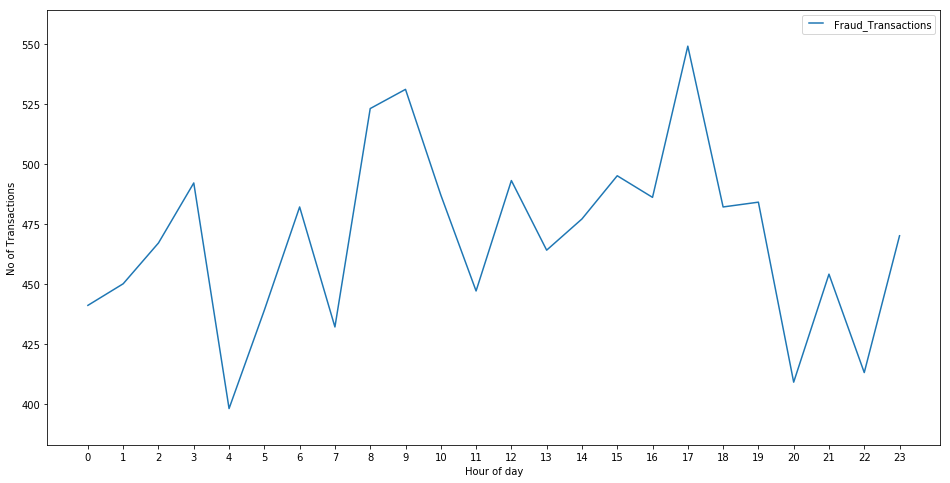

In [64]:
time_series2 = pd.DataFrame(fraud_df['h'].value_counts().sort_index())
fig, ax = plt.subplots(figsize = (16,8))
#time_series.loc[:].plot(ax = ax,label='continuous')
time_series2.loc[:].plot(ax = ax,label='continuous')
ax.margins(None,0.1)
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.legend(['Fraud_Transactions'], loc = 'upper right', numpoints = 3)
ax.set_xlabel('Hour of day')
ax.set_ylabel('No of Transactions')
ax.set_facecolor('white')

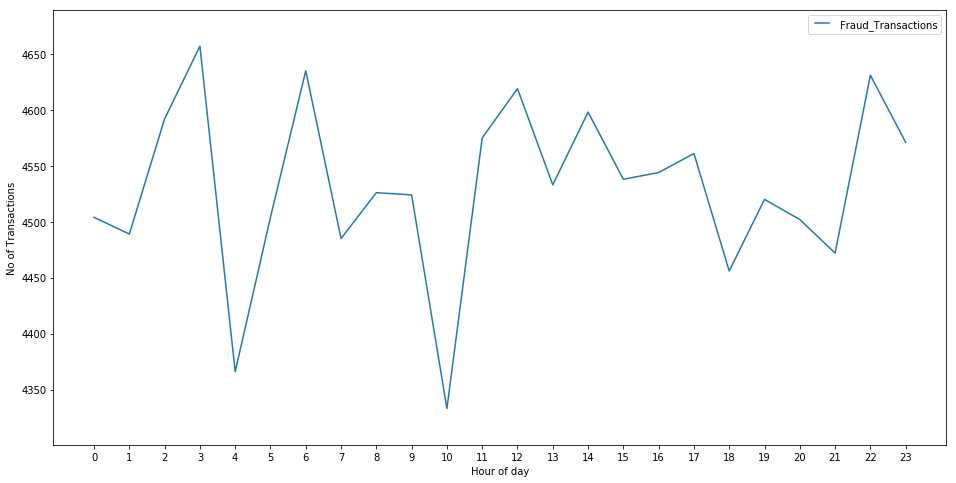

In [66]:
fig, ax = plt.subplots(figsize = (16,8))
time_series.loc[:].plot(ax = ax,label='continuous')
#time_series2.loc[:].plot(ax = ax,label='continuous')
ax.margins(None,0.1)
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.legend(['Fraud_Transactions'], loc = 'upper right', numpoints = 3)
ax.set_xlabel('Hour of day')
ax.set_ylabel('No of Transactions')
ax.set_facecolor('white')

Hour "zero" corresponds to the 12am and  "23" to 11pm. From the above visulaizations, 7 to 11 and 16 to 18 seems to be peak time when fraud tends to occur at higher rates. However, this might be one of the features to classify the transactions, but may not be the one that contributes to the model most.

#### Gender Based Visualization

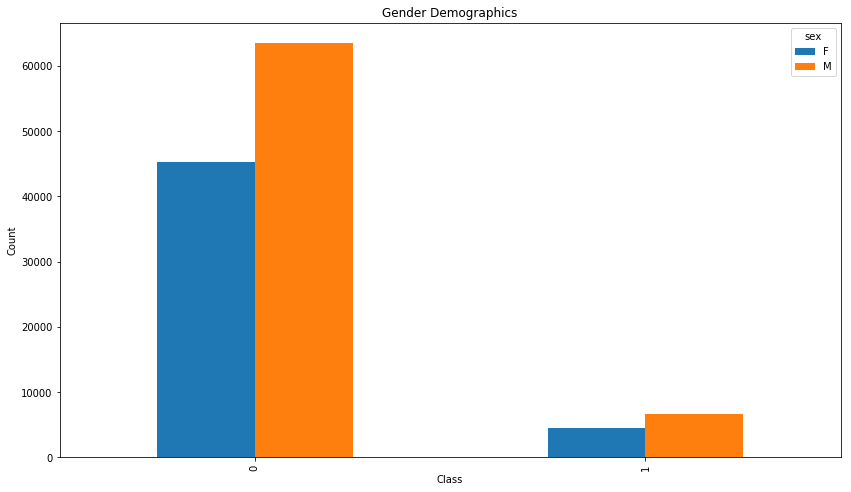

In [75]:
ax = df.groupby(['sex','class'])['class'].count().unstack(0).plot.bar(title="Gender Demographics", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

#### Age Group Visualiztion

In [79]:
def age_form(dl):
    if 18< dl < 25: return 'Youth'
    elif 25 <= dl <= 40: return 'Adults'
    elif 41 < dl <= 64: return 'Middle Age'
    elif dl > 64: return 'Old'
    else: return 'None'

df["age_group"] = df['age'].map(age_form)

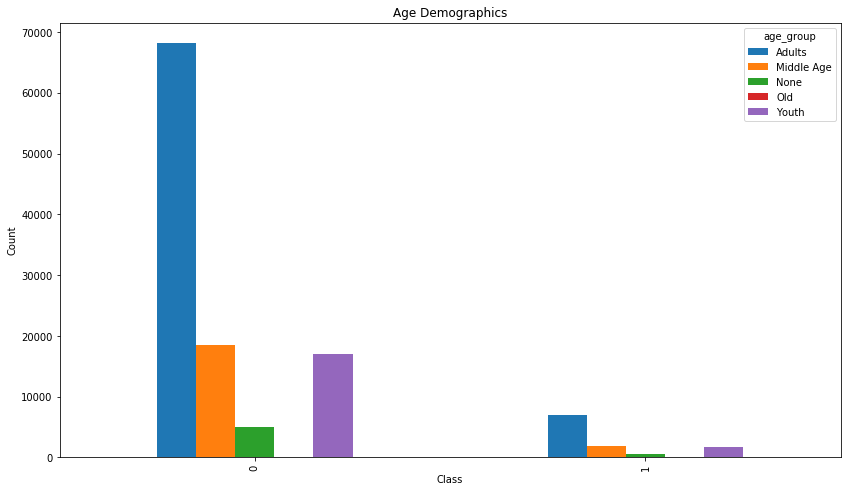

In [81]:
ax = df.groupby(['age_group','class'])['class'].count().unstack(0).plot.bar(title="Age Demographics", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

Mostly adults from age 25 to 41 are involved in such activities. This seems to be a potential feature that can contribute as a feture for model. Assumptions are also applied as a pesron may not give his exact age but a range will essentially help in capturing information through this.

#### Browser Type Visualization</h4>

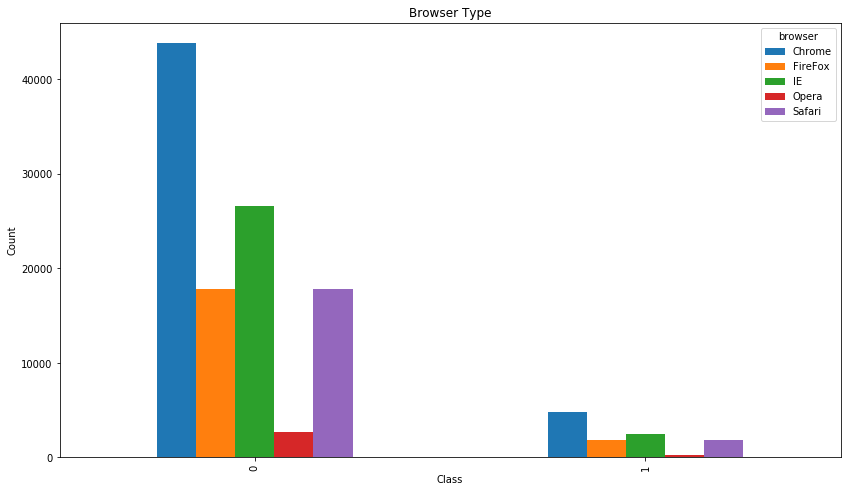

In [83]:
ax = df.groupby(['browser','class'])['class'].count().unstack(0).plot.bar(title="Browser Type", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

#### Weeks Difference between Signup and Purchase Visualization

Text(0,0.5,'Count')

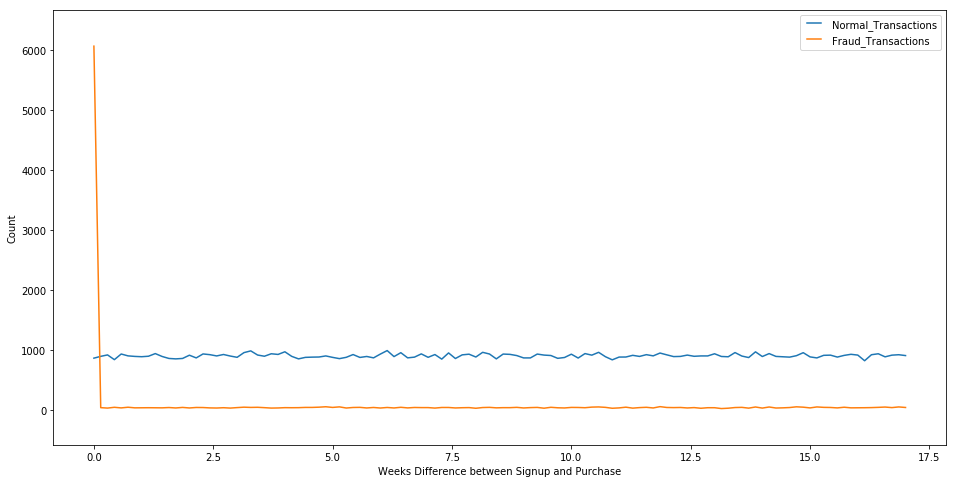

In [88]:
normal_df['purchase_time']=normal_df['purchase_time'].astype('datetime64[ns]')
normal_df['signup_time']=normal_df['signup_time'].astype('datetime64[ns]')
fraud_df['purchase_time']=fraud_df['purchase_time'].astype('datetime64[ns]')
fraud_df['signup_time']=fraud_df['signup_time'].astype('datetime64[ns]')

normal_df['td'] = normal_df['purchase_time']-normal_df['signup_time']
fraud_df['td'] = fraud_df['purchase_time']-fraud_df['signup_time']
normal_df['diff_weeks'] = normal_df['td'].apply(lambda x: round(int(x.days))/7)
fraud_df['diff_weeks'] = fraud_df['td'].apply(lambda x: round(int(x.days))/7)
time_series = pd.DataFrame(normal_df['diff_weeks'].value_counts().sort_index())
time_series2 = pd.DataFrame(fraud_df['diff_weeks'].value_counts().sort_index())
fig, ax = plt.subplots(figsize = (16,8))
time_series.loc[:].plot(ax = ax,label='continuous')
time_series2.loc[:].plot(ax = ax,label='continuous')
ax.margins(None,0.1)
#ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.legend(['Normal_Transactions','Fraud_Transactions'], loc = 'upper right', numpoints = 3)
ax.set_xlabel('Weeks Difference between Signup and Purchase')
ax.set_ylabel('Count')
#ax.set_facecolor('white')

This visualzation depicts the difference between signup and purchase time. I was assuming the fraudlent actvities should have less then a week of interval i.e. when the hackers create accounts he steals the information immediately and closes the account. But that doesn't seem to be happening here and no pattern is merging out of it. As a result we can ignore this feature. This seems to me as base security layer for all ecommerce companies as duration of account plays important role in defining user's trustability.

#### Country Fraud-Normal Visualization

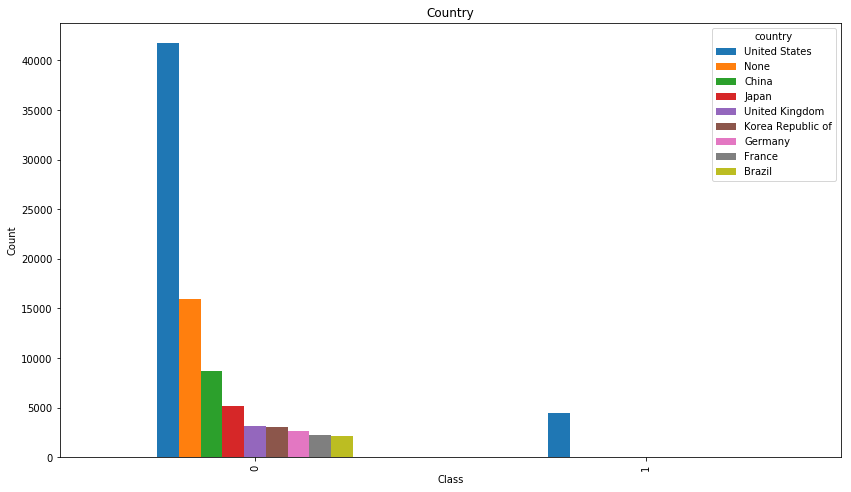

In [147]:
ax = df.groupby(['country','class'])['class'].count().nlargest(10).unstack(0).plot.bar(title="Country", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

From the country based fraudlent activites, it seems that all of the ip addresses that belong to fraud activities are associated with Unites States. This may help us in improvind the classifier.

#### IP Address Visualization

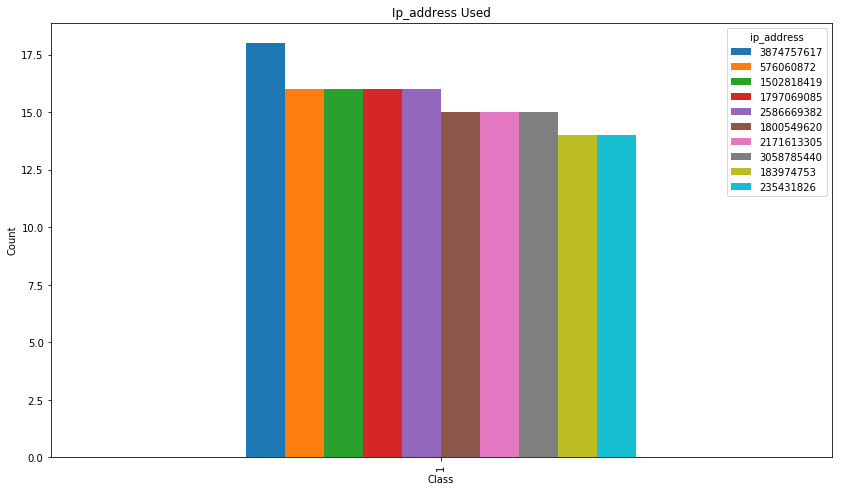

In [104]:
ax = df.groupby(['ip_address','class'])['class'].count().nlargest(10).unstack(0).plot.bar(title="Ip_address Used", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

I am skeptical about i to be used as feature as IP address can be changed anytime and attack can be launched from randomly generated addresses. Also, Ip addresss can tell us about country origin and will essentially have same information.

#### Source Type Visualization

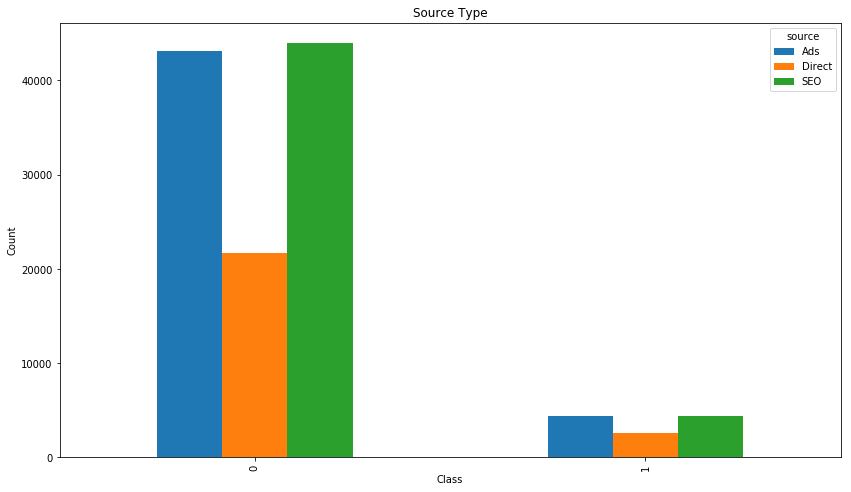

In [118]:
ax = df.groupby(['source','class'])['class'].count().nlargest(10).unstack(0).plot.bar(title="Source Type", figsize=(14,8))
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

The source type doesn't seem to give us any information, but still we will keep it as feature.

#### Correlation Plot

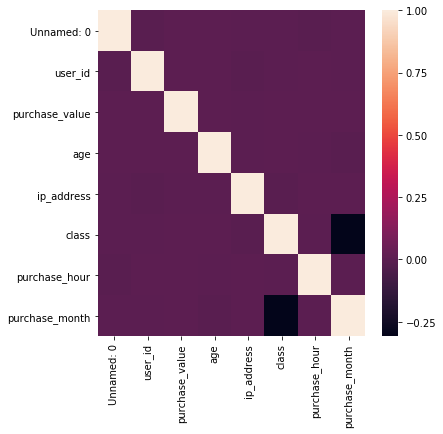

In [455]:
corr = df.corr()
plt.figure(figsize=(6, 6))

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


There seems to be no coorelation between the features.

###  Data Preprocessing

<br>
<h5>From the above analysis, we do have infered some potential features for classifying the fraudlent activities.</h5><br>
<b>To summarize, from preliminary analysis features to be considered are</b><br>
    1) country<br>
    2) Purchase value<br>
    3) Age Group<br>
    4) Gender<br>
    5) Hour of the day<br>
    6) Month of transaction<br>
    7) Source Type<br>

In [114]:
df[['purchase_hour','m','s']] = df['purchase_t'].astype(str).str.split(':', expand=True).astype(int)
#Adding feature for which hour of the day product was brought
del df['m']
del df['s']
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_dates,purchase_t,age_group,purchase_hour
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2818400139,0,,2015-09-10,14:17:56,Middle Age,14
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0,United Kingdom,2015-04-13,04:53:55,Youth,4
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2727760440,0,United States,2015-04-05,12:23:49,Adults,12
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2083419525,0,Korea Republic of,2015-01-09,10:12:06,Adults,10
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3207912663,0,Brazil,2015-04-09,14:26:10,Adults,14


In [458]:
df[['m','purchase_month','s']] = df['purchase_dates'].astype(str).str.split('-', expand=True).astype(int)
#Adding feature for which month product was brought
del df['m']
del df['s']

In [144]:
df.head(10)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_dates,purchase_t,age_group,purchase_hour,purchase_month
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2818400139,0,United States,2015-09-10,14:17:56,Middle Age,14,9
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0,United Kingdom,2015-04-13,04:53:55,Youth,4,4
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2727760440,0,United States,2015-04-05,12:23:49,Adults,12,4
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2083419525,0,Korea Republic of,2015-01-09,10:12:06,Adults,10,1
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3207912663,0,Brazil,2015-04-09,14:26:10,Adults,14,4
5,103053,178528,2015-04-20 20:19:35,2015-08-03 20:17:47,35,HUFZWLDYJPRCK,SEO,Chrome,F,30,2550203819,0,United States,2015-08-03,20:17:47,Adults,20,8
6,71773,323775,2015-06-30 07:34:31,2015-09-05 16:59:33,28,DLOOEWQCUQRKZ,SEO,Safari,M,47,4075993923,0,None,2015-09-05,16:59:33,Middle Age,16,9
7,143439,69189,2015-03-10 01:53:23,2015-06-30 17:37:02,21,NRJPZDBHXNQJG,SEO,FireFox,F,47,2753449046,0,Germany,2015-06-30,17:37:02,Middle Age,17,6
8,101025,70424,2015-07-05 16:54:42,2015-08-25 16:08:56,43,YDLNPVEWMTMMZ,Direct,IE,M,40,3310808206,0,South Africa,2015-08-25,16:08:56,Adults,16,8
9,63154,328496,2015-07-23 12:48:07,2015-10-20 13:01:20,40,HTOCRWCBYIQJI,Ads,Safari,M,33,2185371169,0,France,2015-10-20,13:01:20,Adults,13,10


In [360]:
df_new = df.filter(['user_id','purchase_value'
                    ,'source','sex','age_group','country','purchase_hour','purchase_month','class'], axis=1)

In [361]:
df_new.head(10)

,user_id,purchase_value,source,sex,age_group,country,purchase_hour,purchase_month,class
0,285108,31,Direct,M,Middle Age,United States,14,9,0
1,131009,31,SEO,F,Youth,United Kingdom,4,4,0
2,328855,16,Direct,M,Adults,United States,12,4,0
3,229053,29,SEO,M,Adults,Korea Republic of,10,1,0
4,108439,26,Ads,M,Adults,Brazil,14,4,0
5,178528,35,SEO,F,Adults,United States,20,8,0
6,323775,28,SEO,M,Middle Age,None,16,9,0
7,69189,21,SEO,F,Middle Age,Germany,17,6,0
8,70424,43,Direct,M,Adults,South Africa,16,8,0
9,328496,40,Ads,M,Adults,France,13,10,0


In [150]:
df_new.isna().sum()

user_id           0
purchase_value    0
source            0
sex               0
age_group         0
country           0
purchase_hour     0
purchase_month    0
class             0
dtype: int64

<h3>Encoding categorical variables</h3><br>
To convert categorical data into model-understandable numerical data, we will use One Hot encoding

In [376]:
def OneEncode(original_dataframe):
    columnsToEncode = list(df_new.select_dtypes(include=['category','object']))
    dummies = pd.get_dummies(df_new[columnsToEncode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [377]:
df_one=OneEncode(df_new)
df_one=df_one.select_dtypes(exclude=['category','object'])
df_one.head()

,user_id,purchase_value,purchase_hour,purchase_month,class,source_Ads,source_Direct,source_SEO,sex_F,sex_M,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,285108,31,14,9,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,131009,31,4,4,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,328855,16,12,4,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,229053,29,10,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,108439,26,14,4,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [378]:
df_new.isna().sum()

user_id           0
purchase_value    0
source            0
sex               0
age_group         0
country           0
purchase_hour     0
purchase_month    0
class             0
dtype: int64

<h3>Splitting datset into train,test and valid</h3>
<br>
-Training: 80% - 96000
<br>-Testing and Validation: 20% - 24000
<br> -- Testing(70%): 16800
<br> -- Validation(30%): 7200

In [416]:
def split(df_new):
    fraud_df = shuffle(df_new[df_new["class"] == 1])
    normal_df = shuffle(df_new[df_new["class"] == 0])
    X_train = pd.concat([fraud_df.sample(frac=0.8), normal_df.sample(frac = 0.8)], axis = 0)
    rem_ = df_new.loc[~df_new.index.isin(X_train.index)]
    X_test = rem_.sample(frac=0.7)
    X_valid = rem_.loc[~rem_.index.isin(X_test.index)]
    return X_train,X_test,X_valid

In [417]:
X_one_train,X_test_one,X_valid_one=split(df_one)

In [418]:
def target_(X_train,X_test,X_valid):
    y_train = X_train["class"]
    y_test = X_test["class"]
    y_valid = X_valid["class"]
    del X_train["class"]
    del X_test["class"]
    del X_valid["class"]
    return y_train,y_test,y_valid
    

In [419]:
y_train_one,y_test_one,y_valid_one=target_(X_one_train,X_test_one,X_valid_one)
list(X_one_train.columns)

['user_id',
 'purchase_value',
 'purchase_hour',
 'purchase_month',
 'source_Ads',
 'source_Direct',
 'source_SEO',
 'sex_F',
 'sex_M',
 'age_group_Adults',
 'age_group_Middle Age',
 'age_group_None',
 'age_group_Old',
 'age_group_Youth',
 'country_Afghanistan',
 'country_Albania',
 'country_Algeria',
 'country_Angola',
 'country_Antigua and Barbuda',
 'country_Argentina',
 'country_Armenia',
 'country_Australia',
 'country_Austria',
 'country_Azerbaijan',
 'country_Bahamas',
 'country_Bahrain',
 'country_Bangladesh',
 'country_Barbados',
 'country_Belarus',
 'country_Belgium',
 'country_Belize',
 'country_Benin',
 'country_Bermuda',
 'country_Bhutan',
 'country_Bolivia',
 'country_Bosnia and Herzegowina',
 'country_Botswana',
 'country_Brazil',
 'country_British Indian Ocean Territory',
 'country_Brunei Darussalam',
 'country_Bulgaria',
 'country_Burkina Faso',
 'country_Cambodia',
 'country_Cameroon',
 'country_Canada',
 'country_Cape Verde',
 'country_Cayman Islands',
 'country_Chil

In [313]:
def save_data(X_train,X_test,X_valid,y_train,y_test,y_valid,filename):
    dataset = {'X_train' : X_train,'X_test': X_test,'X_valid': X_valid,
           'y_train': y_train,'y_test': y_test,'y_valid': y_valid}
    with open(filename, 'wb+') as f:
               pickle.dump(dataset, f)

### Machine Learning

#### Confusion Matrix Function

In [254]:
def plot_confusion_matrix(y_test, pred):
    cm = confusion_matrix(y_test, pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    print('---Metrics--------')
    print(classification_report(y_test,pred))


#### Baselines

##### SVM

In [399]:
# Function for traing SVM
def linear_svm(f):
    with open(f, 'rb+') as f:
        dataset = pickle.load(f)
    lsvm = svm.LinearSVC(C=0.1, dual=False)
    lsvm.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm.predict(dataset['X_test'])
    plot_confusion_matrix(dataset['y_test'], y_pred)
    print("AUCROC:--")
    print(roc_auc_score(dataset['y_test'], y_pred))
  

In [420]:
save_data(X_one_train,X_test_one,X_valid_one,y_train_one,y_test_one,y_valid_one,"OneHot.pkl")

---Metrics--------
             precision    recall  f1-score   support

          0       0.90      1.00      0.95     15200
          1       0.00      0.00      0.00      1600

avg / total       0.82      0.90      0.86     16800

AUCROC:--
0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


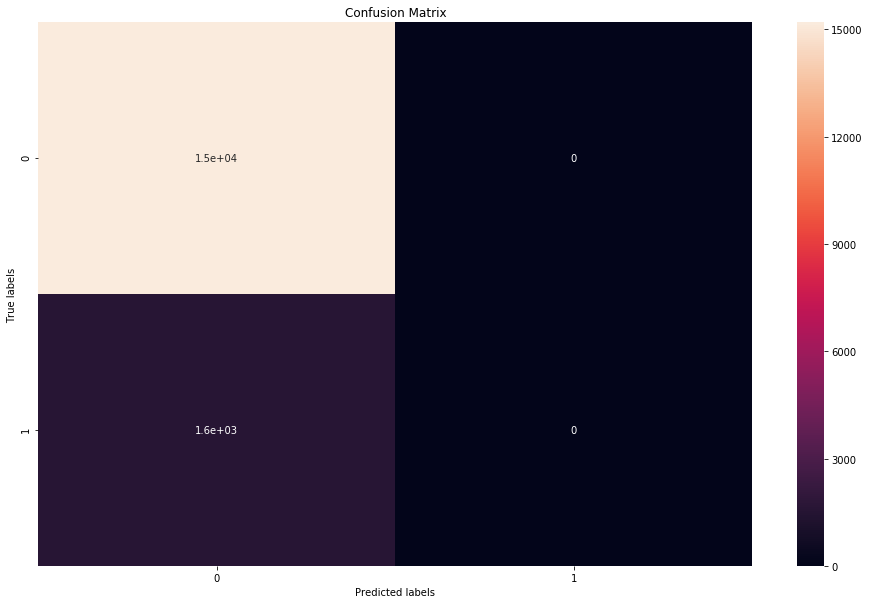

In [421]:
linear_svm("OneHot.pkl")

Model is unable to classify the poistive class correctly and essentially the decison boundary seems to be non linear and hence, some non linear models need to be implemeted. We will start with <b>Random Forest</b>.

##### Random Forest

In [453]:
# Function for Random Forest
def rf(f):
    with open(f, 'rb+') as f:
        dataset = pickle.load(f)
    rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
    forest=rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])
    plot_confusion_matrix(dataset['y_test'], y_pred)
    print("AUCROC:--")
    print(roc_auc_score(dataset['y_test'], y_pred))
    return forest


---Metrics--------
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     15200
          1       0.84      0.54      0.66      1600

avg / total       0.94      0.95      0.94     16800

AUCROC:--
0.7641447368421053


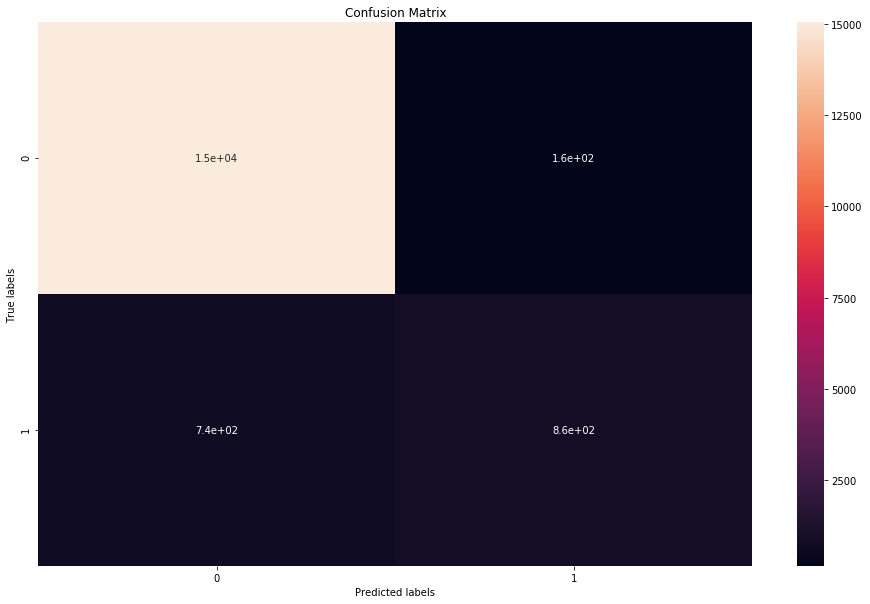

In [424]:
m=rf("OneHot.pkl")

Our model with was able to achieve 95% precision for the negative class label i.e. Normal transaction.This was expected since we’re dealing with imbalanced data, so for the model it’s easy to notice that predicting everything as negative class will reduce the error.
Whereas recall is 51% for the positive class (fraud).
To understand whats going on lets see one more metric known as Area Under the Receiver-Operating Characteristic (AUROC) metric. AUROC represents the likelihood of your model distinguishing observations from two classes. In simple words, if you randomly select one observation from each class, what’s the probability that your model will be able to “rank” them correctly?
For this model its 74% likely it will classify correctly.

<br>
<br>

##### eXtreme Gradient Boosting

In [402]:
#Function for XGB
def XGB(f):
    with open(f, 'rb+') as f:
        dataset = pickle.load(f)
    model = XGBClassifier()
    model.fit(dataset['X_train'], dataset['y_train'])
    y_pred = model.predict(dataset['X_test'])
    plot_confusion_matrix(dataset['y_test'], y_pred)
    print("AUCROC:--")
    print(roc_auc_score(dataset['y_test'], y_pred))

---Metrics--------
             precision    recall  f1-score   support

          0       0.95      0.98      0.97     15200
          1       0.76      0.55      0.64      1600

avg / total       0.94      0.94      0.94     16800

AUCROC:--
0.7651480263157895


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


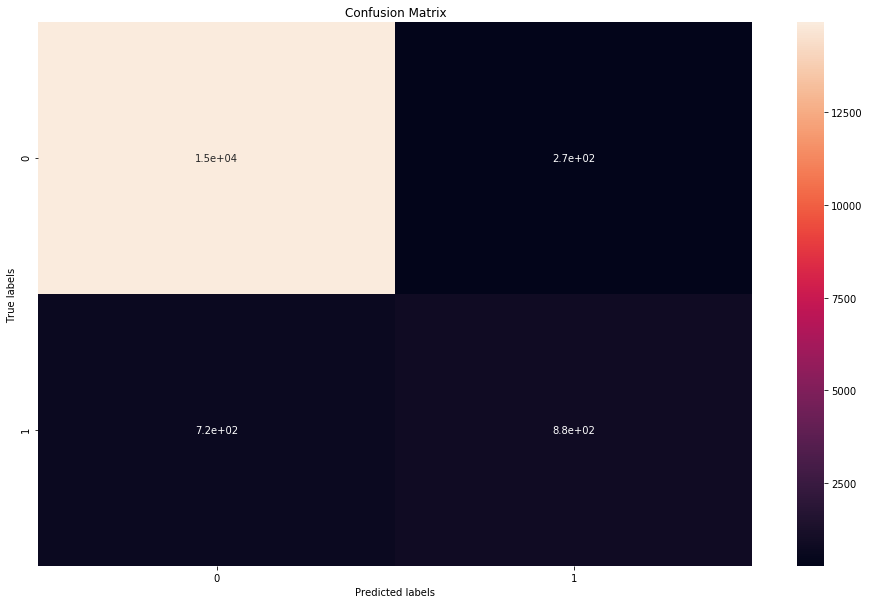

In [425]:
XGB("OneHot.pkl")

In the end, by using RF AND XGB , we were able to improve our recall for the positive class by 55% — we reduced false negatives. Now, models may not help improve more, we need to look for sampling technique that will help us increase data and also recall for positive class.

#### Sampling

<h3>Ways to Handle Imbalanced data set:<br></h3>
    1) Undersampling<br>
    2) Oversampling<br>
<br>For this I will be using oversampling technique "ADASYN" quite simillar to  SMOTE just with a minor improvement. The way it works is after creating those sample it adds a random small values to the points thus making it more realistic.

In [426]:

ada = ADASYN()
X_train,X_test,X_valid=split(df_one)


In [427]:
data_resampled, data_labels_resampled = ada.fit_sample(np.array(X_train.ix[:, X_train.columns != 'class']), 
               np.array(X_train["class"]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [428]:
data_resampled.shape

(177544, 191)

In [429]:
data_labels_resampled.shape

(177544,)

In [430]:
with open('data_res.pkl', 'wb+') as f:
    pickle.dump(data_resampled, f)
with open('data_label.pkl', 'wb+') as f:
    pickle.dump(data_labels_resampled, f)


In [431]:

with open('data_res.pkl', 'rb') as f:
    X_train_resampled = pickle.load(f)
with open('data_label.pkl', 'rb') as f:
    X_train_labels_resampled = pickle.load(f)
    
print(Counter(X_train_labels_resampled))

Counter({1: 90556, 0: 86988})


In [432]:
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_labels_resampled = pd.DataFrame(X_train_labels_resampled)
X_train_resampled = pd.concat([X_train_resampled, X_train_labels_resampled], axis=1)
X_train_resampled.columns = X_train.columns
X_train_resampled.head()

,user_id,purchase_value,purchase_hour,purchase_month,class,source_Ads,source_Direct,source_SEO,sex_F,sex_M,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,265534,32,9,10,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,23137,20,21,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
2,101142,21,8,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,300367,61,7,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,322684,17,17,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [433]:
X_train,X_test,X_valid=split(X_train_resampled)

In [440]:
y_train_one,y_test_one,y_valid_one=target_(X_train,X_test,X_valid)

In [441]:
save_data(X_train,X_test,X_valid,y_train_one,y_test_one,y_valid_one,"OneHot_r.pkl")

#### Random Forest with 100 estimators

---Metrics--------
             precision    recall  f1-score   support

          0       0.94      0.99      0.96     17786
          1       0.96      0.83      0.89      7070

avg / total       0.94      0.94      0.94     24856

AUCROC:--
0.910449376852032


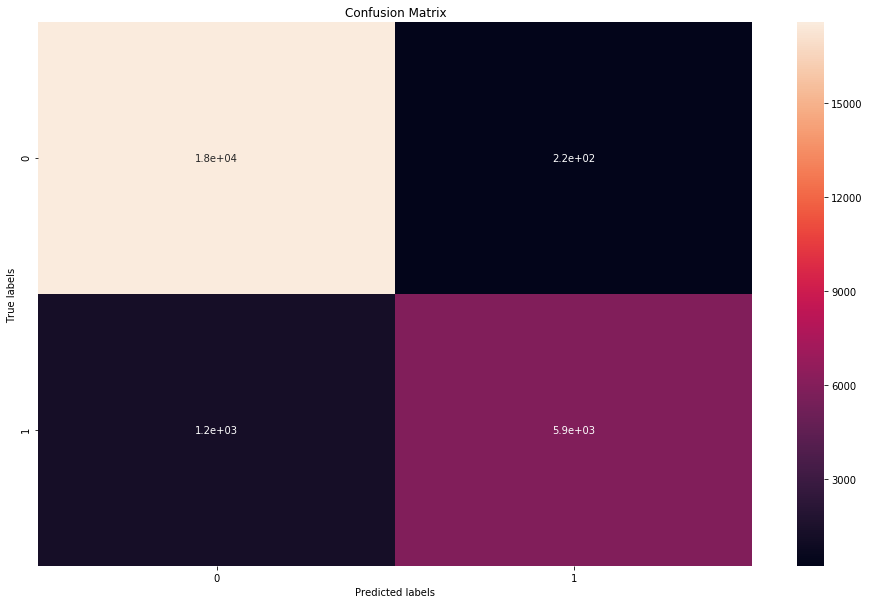

In [446]:
m=rf("OneHot_r.pkl")

Random forest has a good recall score i.e. 83% which is 29% better. Oversampling helped in increasing the instances of negative class and hence, improving both precison and recall. Also, the AUCROC score is 91% which is quite good.

#### XGB

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


---Metrics--------
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     17786
          1       1.00      0.70      0.82      7070

avg / total       0.92      0.91      0.91     24856

AUCROC:--
0.8486571769255447


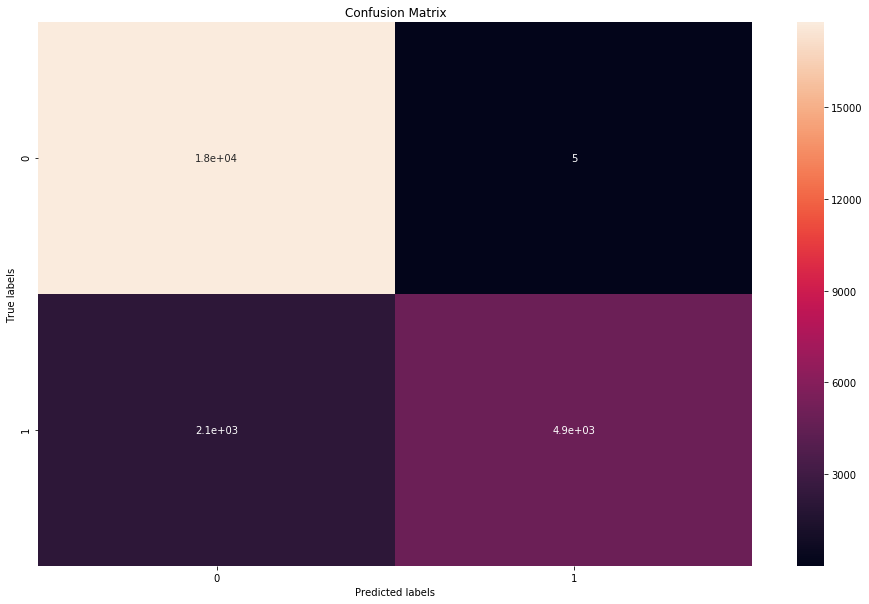

In [447]:
XGB("OneHot_r.pkl")

For XGB, we have recall of 70% for positive class i.e. less then Random Forest. But precison is 100% for negative class. 
<br>
<br>

#### Random Forest with 1000 estimators

---Metrics--------
             precision    recall  f1-score   support

          0       0.94      0.99      0.96     17786
          1       0.97      0.83      0.90      7070

avg / total       0.95      0.94      0.94     24856

AUCROC:--
0.9113107650582892


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

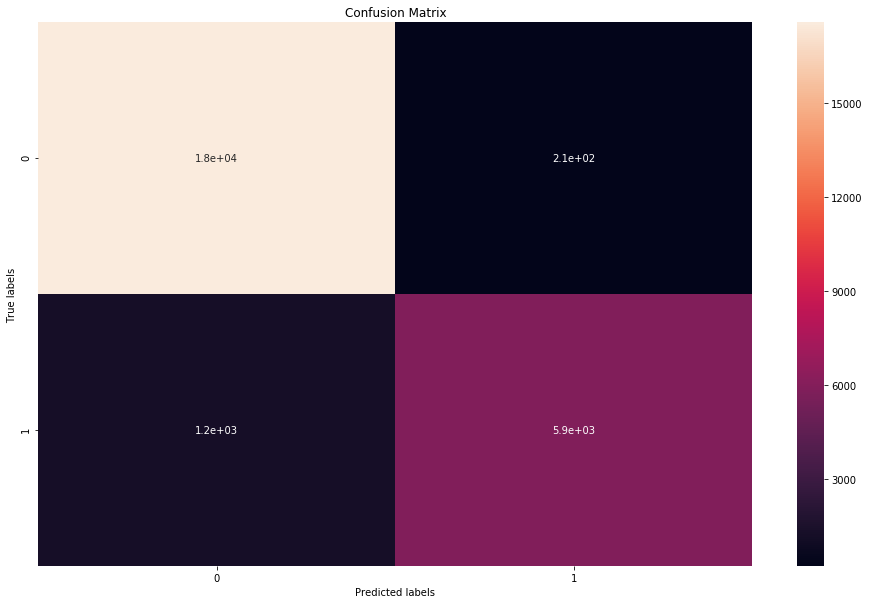

In [448]:
def rf(f):
    with open(f, 'rb+') as f:
        dataset = pickle.load(f)
    rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=4)
    forest=rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])
    plot_confusion_matrix(dataset['y_test'], y_pred)
    print("AUCROC:--")
    print(roc_auc_score(dataset['y_test'], y_pred))
    return forest
rf("OneHot_r.pkl")

After incresing the number of estimators from 100 to 1000 there seems to be increase in precison by 1%, but recall stays same. Hence, we should keep the estimators value same i.e. 100.

#### Top 10 features using Random Forest

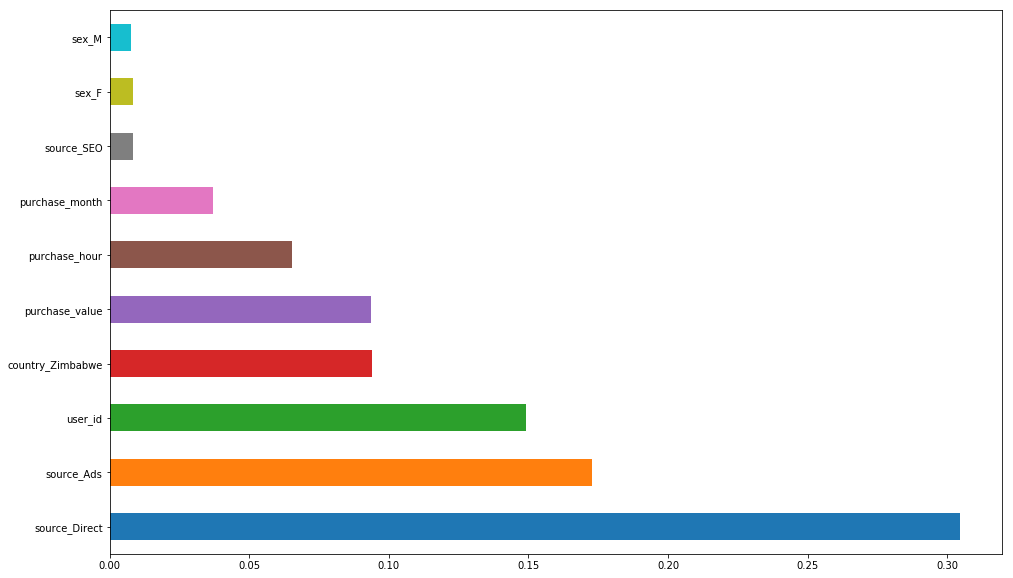

In [452]:
def rf_feature(forest):
    with open("OneHot_r.pkl", 'rb+') as f:
        dataset = pickle.load(f)
    (pd.Series(forest.feature_importances_, index=dataset['X_train'].columns).nlargest(10).plot(kind='barh'))
rf_feature(m)

One of the top features for classification task was Source:= Direct and then its Source:=Ads. These features had significant contributions to the model predictiveness. Also, interestingly country Zimbabwe seems to have quite relevant information.

### Conclusion

<br>After all the experimentaion and trying sampling techniques, Random forest with ADASYN sampling technique performs best with recall of 83% and precison of 96%.
XGB had a better Precison compared to Random Forest at 100% but a recall of 70%.<br>
<br>Now decison of using model depends on Electronica primary purpose.
<br>1) The first option is to keep cusomer happy i.e. avoiding inconveniences to the Electronica customers whose valid transactions are flagged as fraudlent which cost client values at 8 dollars. For this, XGB will be the highly precise model to be used for this purpose.
<br>
<br>2) The second option is when Electronica doesn't want to fail identifying fraudulent transaction because it loses money. The loss is equivalent to the price of the fraudulently purchased product and in this case Random Forest will be better model as Recall is high compared to any other model. That came with a price: our precision is now 4% worse than XGB.
<br>
<br>
<b>In the end, it depends on Electronica which client they want to serve. For example if products are of GUCCI,Rolex, etc. whose products are expensive  i.e value more than $8 then Random Forest will be better choice otherwise, if product are of Dollar Tree etc. i.e. value less than 8 dollars then XGB will be better choice.<b>

### Next Steps

As a next steps, since data is imbalanced implementing autoencoders will be quite interesting. Also, it will be important to include more features such as VPS, Service Provider, State, city etc. which can help in enhancing model predictions.

### END